# Math 170 - Homework 5

### Reference

Feel free to reference the code from the notes for this homework:

https://colab.research.google.com/drive/1UEVsTrisO2F7jwQdmNMnafp6h3uwsUSv?usp=sharing

### Setup

This homework will try to walk you through the basics of gradient descent optimisation using JAX.

To make sure you have all the relevant dependencies installed run the following in your terminal:

To check you have everything installed properly and to import them to this notebook run the follow code:

In [3]:
import numpy as np
from jax import jit, lax, random
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jla

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

In [4]:
from tqdm import tqdm

As an extra step we also initialise a random seed for ease of debugging.

In [5]:
key = random.PRNGKey(0) 

You are welcome to try code up the homework in another language if you like, although we won't be providing starter code unfortunately outside of Python.

## Overview

You will be implementing least squares regression as well as a classifier on the MNIST (https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset. You do not need to download the dataset manually - it is included in the TensorFlow datasets imported in the code above.

We will be making use of the gradient descent method and code from class as the optimiser in the training procedure. As a reminder, to solve the unconstrained convex minimisation problem:

$$ \min_x f(x), $$ 

gradient descent iteratively produces a sequence

$$ x_{t+1} = x_t - \eta \nabla f (x_t) $$

where $x_t$ are the iterates and $\eta$ is the step size (or learning rate). For this homework, we will take $\eta$ to be a fixed constant.

The following code (from the notes) implements the gradient descent algorithm:

In [109]:
def gradient_descent(fgradf, x0, eta, T):
    x = x0
    for t in tqdm(range(0,T+1)):
        fx, gradfx = fgradf(x)
        if fx is None or any(jnp.isnan(gradfx)):
            print("NaN encountered, stopping early")
            break
        x = x - eta * gradfx
        
    return x

Before you proceed, make sure you understand what each of the input and output variables stand for! This is true in general whenever you are writing any code. This means that you need to know:
1. What information does this variable store? (step size, number of gradient descent iterations)
2. What type is the variable? (e.g. integer, array)
3. If it is an array, what should the dimensions be? (e.g. number of observables, number of parameters)

### Question 1:

For each of the inputs and outputs of the gradient_descent function above, answer the three questions above. 

***Fill in your answer below:***

1. fgradg: This is the function that will perform the gradient descent, returning f(x) and the gradient at that specific f(x) point
2. x0: The initial estimate point stored as an tuple of floats
3. eta: The step size stored as a float
4. T: The number of gradient descent iterations stored as a positive integer
5. x: The x value made iteratively, representative of the "zero" of the function

## Linear regression

Let's dive into linear regression! For this problem we are going to generate some data and try to fit our model to this manufactured data. This is quite a common practice when testing a code, as this means we can use the underyling model as a ground truth to evaluate performance.

The function we are going to use as a ground truth is a simple sinusoid

$$ g(t) = \sin(\pi t) $$

We are going to fit to noisy versions of this function. That is we will take $N$ samples

$$ y_n = g(t_n) + \omega $$

where $\omega \sim \mathcal{N}(0,\alpha) $, that is it is normally distributed with mean zero and standard deviation $\alpha$. We will samples the function at $N$ values of $t_n \in [-1,1]$, spaced uniformly. That is each $t_n$ is

$$ t_n = -1 + 2\frac{n-1}{N-1} $$

for $n=1,2,...,N$.

### Question 2:

Write a python function generateLinearData( N, alpha ) that takes in the inputs:
1. N: Number of sample points
2. alpha: Variance of Gaussian noise
   
and generates two output arrays:

1. t: A list of N points in the range [-1,1], this will serve as our t_n
2. y: A list of N points g(t_n) + noise omega

In [50]:
def g(t):
    return jax.numpy.sin( jax.numpy.pi * t )

def generateLinearData( N, alpha ):
    
    """
    Generate noisy observations of g(x) = sin( pi*x )

    Args:
        N (int): Number of data points.
        alpha (float): Standard deviation of Gaussian noise.

    Returns:
        t (jnp.ndarray): Shape (N,), input points in [-1, 1].
        y (jnp.ndarray): Shape (N,), observations g(t) + noise omega.
    """
    
    t = jnp.linspace(-1, 1, N)
    y = jnp.asarray([g(t_n) + (random.normal(key) * alpha) for t_n in t])
    
    return t, y

To check your code, run the following block of code below to plot your data points. Your points should be scattered around the exact function g(x). Note we are picking the standard deviation $\alpha = 0.2$ for the noise.

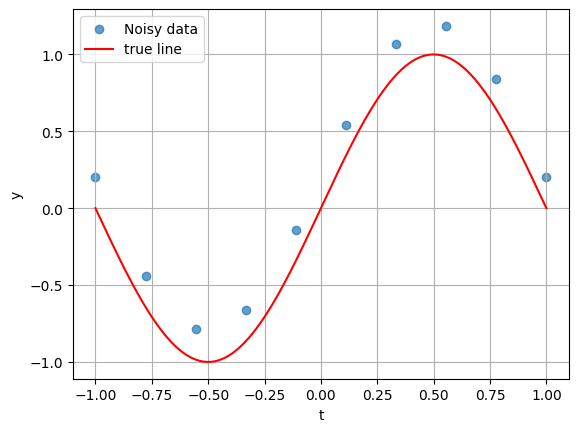

In [51]:
# Generate data
t, y = generateLinearData( 10, 0.2 )
t_dense = jnp.linspace(-1, 1, 500)

# Plot
plt.scatter(t, y, alpha=0.7, label="Noisy data")
plt.plot(t_dense, g(t_dense), color='red', label="true line")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
type(y)

jaxlib._jax.ArrayImpl

### Polynomial regression

The way we are going to fit the data is using polynomial regression. This means that we want to find the best polynomial of degree $q$

$$ p(t) = x_0 + x_1 t + ... + x_q t^q, $$

such that

$$ \min_{x_0,x_1,...,x_q} \frac{1}{N} \sum_{i=1}^N \| p(t_i) - y_i \|_2^2. $$ 

Note that we are using more than just the values $t_n$ to fit the function. Here we are taking powers of $t_n$ as well since this gives us a more expressive features to approximate the data $b_n$ with.

Why might a polynomial be a good fit? Recall from calculus that we can write $\sin(t)$ as a power series using powers of $t$. So you can understand this if you want as trying to recreate that with data.

How to encode the polynomial points $p(t_i)$? We can write

$$ p(t_i) = \begin{pmatrix} 1 \\ t_i \\ t_i^2 \\ \vdots \\ t_i^q \end{pmatrix} \cdot \begin{pmatrix} x_0 \\ x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix}, $$

so that we are overall trying to solve the minimisation problem

$$ \min_{x_0,x_1,...,x_q} \frac{1}{N} \sum_{i=1}^N \bigg\| \begin{pmatrix} 1 \\ t_i \\ t_i^2 \\ \vdots \\ t_i^q \end{pmatrix} \cdot \begin{pmatrix} x_0 \\ x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} - y_i \bigg\|_2^2. $$ 

#### A note on notation

In the notes the linear regression problem is written as

$$ \min_{\beta} \frac{1}{N} \sum_{i=1}^N \| \beta \cdot x_i - y_i \|_2^2. $$

Note here that we have swapped around the variables a bit. To match the notation here with the notes we have replaced the variables

$$ x_i \rightarrow \begin{pmatrix} 1 \\ t_i \\ t_i^2 \\ \vdots \\ t_i^q \end{pmatrix}, ~~~~ \beta \rightarrow \begin{pmatrix} x_0 \\ x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} $$

This might be a little confusing (sorry!), but this has been done to match the notation for gradient descent. This is as the gradient descent notation we have adopted in this class is that we are optimising for $x$, which in this case are the coefficients to the polynomial $x_0,x_1,...,x_q$.

### De-meaning the data

Recall that we can de-mean the data to remove the constant term $x_0$ in the optimisation problem. That is we can replace

$$ t_i \rightarrow t_i - \bar{t}, ~~~~ y_i \rightarrow y_i - \bar{y}, $$

where $\bar{t} = \frac{1}{N} \sum_{i=1} \begin{pmatrix} t_i \\ t_i^2  \\ \vdots \\ t_i^q \end{pmatrix}, ~\bar{y} = \frac{1}{N} \sum_{i=1} y_i,$ are the means of the data. This allows us instead to solve a smaller optimisation problem

$$ \min_{x_1,...,x_q} \frac{1}{N} \sum_{i=1}^N \bigg\| \bigg( \begin{pmatrix} t_i \\ t_i^2  \\ \vdots \\ t_i^q \end{pmatrix} - \bar{t} \bigg) \cdot \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} - (y_i-\bar{y}) \bigg\|_2^2. $$ 

To recover the constant we can simply pick it to be

$$ x_0 = \bar{y} - x^{*} \cdot \bar{t}, $$

where $x^*$ is the minimiser to the optimisation problem (Exercise 2.50).

### Question 3

Your goal for this question will be to build the arrays required to solve the above de-meaned regression problem. To do this you will need to build a feature matrix $A$ where the $i$-th row is

$$ 
\begin{pmatrix} t_i & t_i^2 & ... && t_i^q \end{pmatrix} - \bar{t}^T ,
$$

and a vector
$$
y_0 = 
\begin{pmatrix}
    y_1 - \bar{y} \\
    y_2 - \bar{y} \\
    \vdots\\
    y_N - \bar{y} \\
\end{pmatrix}.
$$

Write a python function generateFeatures( y, t, q ) that takes in as arguments:

1. y: Vector of g(x_n) + noise omega of observed data points
2. t: Points $t_n$ at which y was sampled
3. q: The degree of the polynomial $p(x)$

and returns as output
1. A: The size $N \times q$ matrix $A$
2. y0: The length $N$ vector $y_0$

In [94]:
def generateFeatures( y, t, q ):
    
    """
    Constructs polynomial feature matrix without constant term,
    and mean-centers both the features and the targets.
    
    Args:
        y: jnp.ndarray of shape (N,) - target data
        t: jnp.ndarray of shape (N,) - input data
        q: int - polynomial degree (features go from t^1 to t^q)
    
    Returns:
        A0: jnp.ndarray of shape (N, q) - de-meaned feature matrix
        y0: jnp.ndarray of shape (N,) - de-meaned target vector
    """
    A = jnp.vstack([t**i for i in range(1, q+1)]).T
    A0 = A - jnp.mean(A, axis=0)
    y0 = y - jnp.mean(y)
    

    
    return A0, y0

Once you have implemented your function, run the code below to test your code. Note we are going to fit using a polynomial of degree 10.

In [95]:
### RUN THE CODE HERE TO GENERATE FEATURE MATRIX!
q = 10
A, y0 = generateFeatures( y, t, q )

assert( A.shape == ( len(t), q ) )

In [96]:
type(A), A.shape, A, type(y0), y0.shape, y0

(jaxlib._jax.ArrayImpl,
 (10, 10),
 Array([[-1.0000000e+00,  5.9259260e-01, -1.0000000e+00,  7.0525831e-01,
         -1.0000000e+00,  7.4956954e-01, -1.0000000e+00,  7.7137071e-01,
         -1.0000000e+00,  7.8323388e-01],
        [-7.7777779e-01,  1.9753084e-01, -4.7050756e-01,  7.1208626e-02,
         -2.8462803e-01, -2.9053077e-02, -1.7218240e-01, -9.4709679e-02,
         -1.0415971e-01, -1.3575304e-01],
        [-5.5555558e-01, -9.8765433e-02, -1.7146778e-01, -1.9948182e-01,
         -5.2922159e-02, -2.2102924e-01, -1.6334001e-02, -2.1955486e-01,
         -5.0413585e-03, -2.1396540e-01],
        [-3.3333328e-01, -2.9629636e-01, -3.7037019e-02, -2.8239602e-01,
         -4.1152230e-03, -2.4905869e-01, -4.5724685e-04, -2.2847690e-01,
         -5.0805185e-05, -2.1674922e-01],
        [-1.1111112e-01, -3.9506176e-01, -1.3717429e-03, -2.9458928e-01,
         -1.6935104e-05, -2.5042856e-01, -2.0907544e-07, -2.2862928e-01,
         -2.5811790e-09, -2.1676615e-01],
        [ 1.1111116e-01, 

Make sure your code is not failing the above check!

We have one more step before we are ready to optimise. That is we have to define the objective function. From above, we are minimising

$$ \min_{x_1,...,x_q} \frac{1}{N} \sum_{i=1}^N \bigg\| \bigg( \begin{pmatrix} t_i \\ t_i^2  \\ \vdots \\ t_i^q \end{pmatrix} - \bar{t} \bigg) \cdot \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} - (y_i-\bar{y}) \bigg\|_2^2. $$ 

Note that now we have $A$ we can rewrite this succinctly as

$$ \min_{x_1,...,x_q} \frac{1}{N} \bigg\| A \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} - y_0 \bigg\|_2^2. $$ 

To minimise this we now need to define the $L^2$ loss

$$ \frac{1}{N} \bigg\| A \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} - y_0 \bigg\|_2^2. $$ 

### Question 4

Write a python function l2loss that implements the $L^2$ loss function. The function should take as input:
1. y0: De-meaned data points from above
2. A: Your feature matrix from above
3. x: The vector of polynomial coefficients
   
and return as output:
1. The scalar $L^2$ loss

In [110]:
def l2loss( y0, A, x ):

    """
    Computes the squared L2 loss for a given set of parameters theta:
        Loss = ||A * x - y0||^2

    Args:
        y0 (jnp.ndarray): shape (N,), target values.
        A (jnp.ndarray): shape (N, D), feature matrix.
        x (jnp.ndarray): shape (D,), model parameters.

    Returns:
        loss: Squared L2 loss.
    """
    
    loss = (1 / y0.shape[0]) * jla.norm(A@x - y0)**2
    # print(f"Loss:{loss}")
    
    return loss

We are now ready to optimise! You will now combine your code with the gradient desecent function to find an optimal $\theta$.

### Question 5

Use the following parameters for the gradient descent (numbers have been optimised so you don't have to worry about that).

In [111]:
# Parameters for gradient descent
T = 10000
eta = 0.4
key, subkey = random.split(key)

# Initial guess for gradient descent
x0 = random.normal(subkey,(A.shape[1],))

Using the provided gradient_descent function, find an optimal x vector using:
1) l2loss, function
2) A, feature matrix
3) y0, the de-meaned data points
4) x0, initial guess to gradient descent

Store this in a variable called x_opt.

In [112]:
### YOUR CODE BELOW
#fgradf = jax.value_and_grad(l2loss, argnums=2)
#fgradf = jit(jax.value_and_grad(g))
l2loss_grad = jax.grad(l2loss, argnums=2)
x_opt = gradient_descent(lambda val: (l2loss(y0, A, val), l2loss_grad(y0, A, val)), x0, eta, T)

100%|██████████| 10001/10001 [00:33<00:00, 294.27it/s]


Once you have found x_opt, run the following code to plot your best fit polynomial!

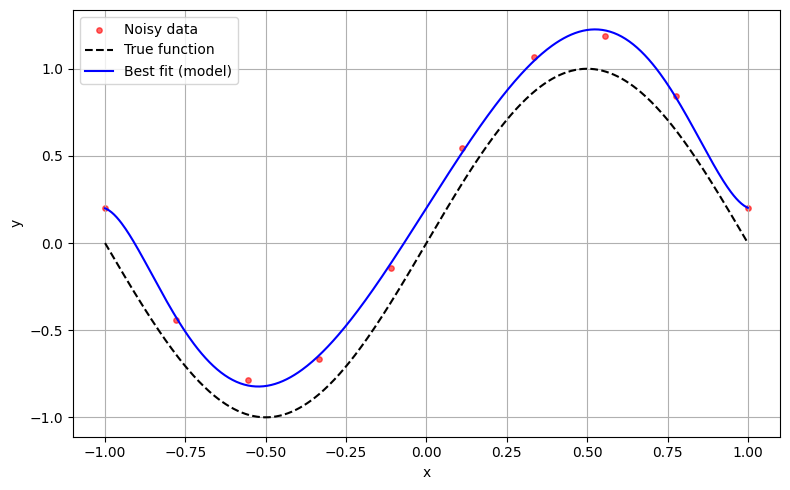

In [113]:
# Generate regression line
xC = jnp.mean(y) - jnp.dot( x_opt, jnp.mean(A, axis=0) )
A_dense, y0 = generateFeatures(y, t_dense, q)
y_fit = A_dense @ x_opt + xC
y_true_dense = g(t_dense)

# Plot original data and best-fit line
plt.figure(figsize=(8, 5))
plt.scatter(t, y, color='red', label='Noisy data', alpha=0.6, s=15)
plt.plot(t_dense, y_true_dense, label='True function', color='black', linestyle='--')
plt.plot(t_dense, y_fit, label='Best fit (model)', color='blue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

How do your results look? You should see a blue line that somewhat follows the shape of the dotted reference sinusoidal function. But how good is the fit? If it doesn't fit as well as you would hope why do you think that is? (Hint: noise)

We will now look at what regularisation can do to help improve the fit. Specifically we will be using Ridge regression for this problem. Recall that this means we add an extra term to the loss function:

$$ \min_{x_1,...,x_q} \sum_{i=1}^N \bigg\| A \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} - y_0 \bigg\|_2^2 + \lambda \bigg\| \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_q \end{pmatrix} \bigg\|_2^2. $$ 

We will use the value $\lambda = 10^{-3}$ for this problem. 

### Question 6

Write a python function l2ridge that implements the ridge regression loss function. The function should take as input:
1. y0: The de-meaned data points from above
2. A: Your feature matrix from above
3. x: The array of polynomial coefficients
   
and return as output:
1. The scalar ridge regression loss

In [114]:
def l2ridge( y0, A, x ):

    """
    Computes the squared L2 loss with ridge regression for a given set of parameters x:
        Loss = ||A * x - y0||^2 + 0.001 * ||x||^2

    Args:
        y0 (jnp.ndarray): shape (N,), target values.
        A (jnp.ndarray): shape (N, D), feature matrix.
        x (jnp.ndarray): shape (D,), model parameters.

    Returns:
        loss: Squared L2 loss.
    """
    
    loss = jla.norm(A@x - y0)**2 + 1e-3 * jla.norm(x)**2
    
    return loss

Again using the provided gradient_descent function, find an optimal x vector using:
1) l2ridge, function
2) A, feature matrix
3) y0, the de-meaned data points
4) x0, initial guess to gradient descent

Store this again in a variable called x_opt. Use the same parameters as above in your gradient descent.

In [115]:
### YOUR CODE BELOW

x_opt = gradient_descent( lambda x: ( l2loss(y0, A, x), jax.grad( lambda x: l2loss(y0, A, x) )(x) ), x0, eta, T )

100%|██████████| 10001/10001 [00:31<00:00, 314.17it/s]


Once you have found x_opt, run the following code to plot your new best fit polynomial.

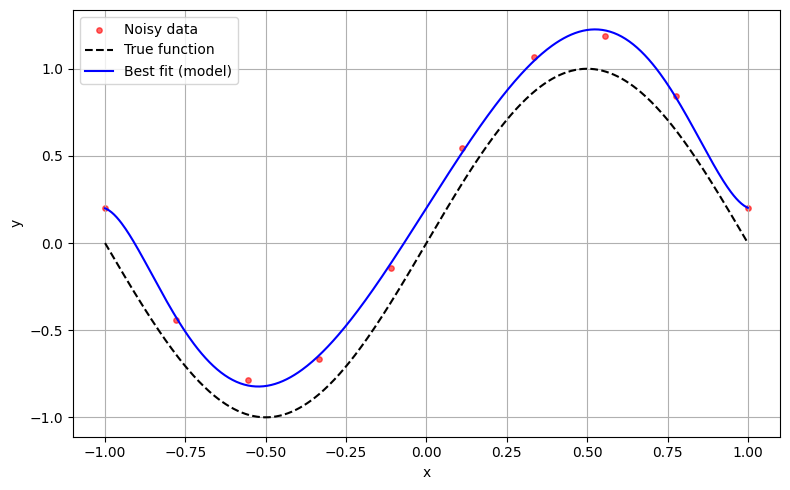

In [117]:
# Generate regression line
xC = jnp.mean(y) - jnp.dot( x_opt, jnp.mean(A, axis=0) )
A_dense, y0 = generateFeatures(y, t_dense, q)
y_fit = A_dense @ x_opt + xC
y_true_dense = g(t_dense)

# Plot original data and best-fit line
plt.figure(figsize=(8, 5))
plt.scatter(t, y, color='red', label='Noisy data', alpha=0.6, s=15)
plt.plot(t_dense, y_true_dense, label='True function', color='black', linestyle='--')
plt.plot(t_dense, y_fit, label='Best fit (model)', color='blue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

How do the results differ? Feel free to play with the parameter $\lambda$ to try understand better what it does!

## Classification

We will now turn our attention to training a classifier for the MNIST dataset. The MNIST dataset (Modified National Institute of Standards and Technology) is one of the most well-known datasets in the field of machine learning and computer vision. It consists of 70,000 grayscale images of handwritten digits (0 through 9), with 60,000 used for training and 10,000 for testing.

Each image is 28x28 pixels, and the goal is to build models that can correctly recognize the digit shown in each image.

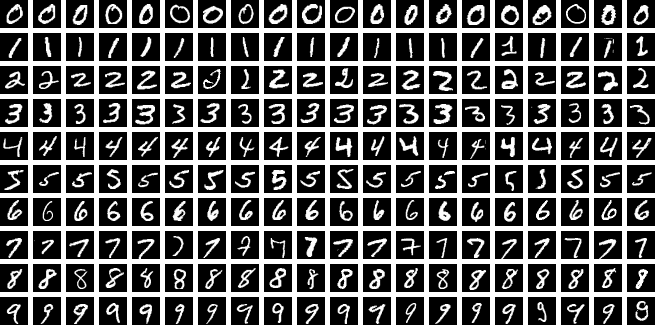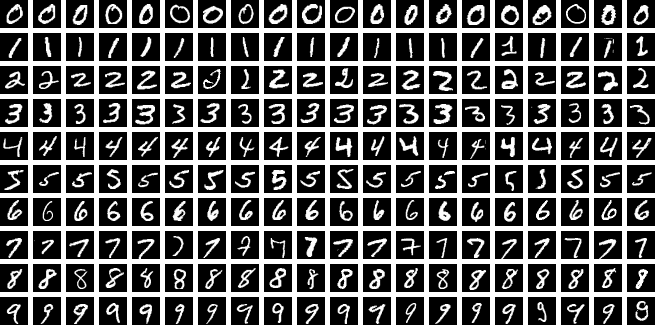

Before we begin, run the following code to load in the MNIST data.

In [35]:
def load_mnist(split):
    ds = tfds.load('mnist', split=split, as_supervised=True)
    ds = ds.map(lambda img, label: (tf.cast(tf.reshape(img, [-1]), tf.float32) / 255.0, label))
    ds = ds.batch(60000 if split == 'train' else 10000)
    ds_numpy = tfds.as_numpy(ds)

    for batch_x, batch_y in ds_numpy:
        return jnp.array(batch_x), jnp.array(batch_y)

X, Y = load_mnist('train')

The code above loads 60000 images from the training dataset into two arrays X, Y. Each image is flattened from a 28x28 matrix into a $28^2 = 784$ entry vector, and collated into the $60000 \times 784$ feature matrix $X$. The array $y$ is a 60000 entry vector that corresponds to the correct labelling of each image (i.e. a label 0-9).

In classification tasks, it's common to convert class labels (like 0, 1, 2, ...) into a format that models can work with more effectively. One-hot encoding is a way to do that.

Instead of assigning numbers like 0, 1, 2 to different categories (which might imply an order), one-hot encoding represents each category as a binary vector where all elements are 0, except for a 1 at the index corresponding to that category.

For example, if we have 3 classes: cat, dog, and rabbit, one-hot encoding would look like:
1. cat    $\rightarrow [ 1, 0, 0 ]$  
2. dog    $\rightarrow [ 0, 1, 0 ]$  
3. rabbit $\rightarrow [ 0, 0, 1 ]$  

### Question 7
Write code below to apply one-hot encoding to the vector of labels $Y$. Store the result in a variable $E$.

In [36]:
### YOUR CODE HERE
E = jax.nn.one_hot(Y, 10)

***We will be minimising the cross-entropy loss for multi-class classification using softmax via gradient descent.***

The input array $X$ with columns denoted $x_i$ is transformed using a weight matrix $W \in \mathbb{R}^{K \times n}$ and $b \in \mathbb{R}^K$
$$ W x_i + b. $$
This linear transformation is applied to each column. The softmax function is then applied as
$$ \sigma( W x_i + b ) $$ 
where we have introduced the notation $\sigma$ for the softmax function. This is the notation commonly used in machine learning applications where it is known as an activation function. Specifically here we are choosing softmax as the activation function for this classification problem.

### Question 8
Identify what the dimensions $K,n$ are equal to in this case.

***Fill in your answer below***

K is the weight for each datapoint for each image so it is 10. n is 784 for each of the pixels

The loss term we will use is the cross-entropy loss

$$ \min_{W,b} \sum_{i=1}^{60000} -y_i \log \bigg(( \sigma(W x_i + b ) \bigg). $$

where $y_i$ are the entries of $Y$. We will be minimising this using gradient descent.

Code implementing the loss function, as well as for gradient descent has been provided. These have been taken directly from the notes. Run the following block to load the functions.

In [125]:
@jit
def lossterm(x,ey,params):
    W,b = params
    return -jnp.dot(ey,jax.nn.log_softmax(W@x + b))

# batch across the dataset
lossterm_batch = jit(jax.vmap(lossterm,in_axes=(0,0,None)))

# build objective, now treating X and E (dataset) as constant
@jit
def f(params):
    return jnp.mean( jnp.sum(lossterm_batch(X,E,params)) )

# JAX can do automatic differentiation with respect to tuple of inputs
fgradf = jit(jax.value_and_grad(f))

def gd_params(fgradf, params0, eta, T):

    params = params0
 
    # main loop
    for t in tqdm(range(0,T+1)):
        val, grads = fgradf(params)
        tmp = 0
        newparams = []
        for i in range(len(params)):
            newparams.append( params[i] - eta * grads[i] )
            tmp += jla.norm(grads[i])**2
        params = tuple(newparams)

    # return final parameters as well as objective and gradient norm history
    return params

### Question 9

You will now use the gradient descent function provided above to optimise for $W,b$. For this task:

1. Initialise a array for $W, b$ of all zeros.
2. Run gradient descent using the paramaters T = 1000, eta = 0.005. Store the result in an array params

You will need to make use of the code block above. Make sure you read it carefully!

In [126]:
#YOUR CODE HERE
W = jnp.zeros((10, 784))
b = jnp.zeros((10,))
params = gd_params(fgradf, (W,b), 0.005, 1000)

100%|██████████| 1001/1001 [00:43<00:00, 23.08it/s]


Once you have found params, run the code block below to test your optimised classifier. How does it do?

In [127]:
@jit
def predict_probvec(X, params):
    W, b = params
    probvec = jax.nn.softmax(W @ X + b)
    return probvec

probvecs = jax.vmap(predict_probvec, in_axes = (0,None) )(X,params)
print( "Percentage of labels correctly predicted: ", 1 - jnp.sum(jnp.any(E-probvecs != 0, axis=1)) / 60000 )

Percentage of labels correctly predicted:  0.7097833


We can try to improve on this by introducing what is called another layer to the problem. Right now what we do is transform $X$ via

$$ X \rightarrow \sigma( W x_i + b ). $$

The idea of introducing another layer is to apply a separate transform to $X$ before applying the softmax. One possiblity is to apply a ReLU (rectified linear unit) layer

$$ X \rightarrow \sigma( W_1 x_i + b_1 ) \rightarrow \sigma \bigg( W_2 ~ \mathrm{ReLU}( W_1 x_i + b_1 ) + b_2 \bigg) $$

This gives us a bigger space to search over to find a better classifier. This comes at the cost of having more things to optimise over

$$ \min_{W_1, W_2, b_1, b_2} \sum_{i=1}^{60000} -y_i \log \bigg( \sigma \bigg( W_2 ~ \mathrm{ReLU}( W_1 x_i + b_1 ) + b_2 \bigg) \bigg). $$

### Question 10

Modify the following code to implement the hidden layer in the loss function. Use the built in JAX function for the ReLU. You will have to look up the JAX documentation for this. (This is a really good practice to get into and will be something you have to do a lot in real applications!)

In [130]:
@jit
def lossterm(x, ey, params):
    W1, b1, W2, b2 = params
    return -jnp.dot(ey, jax.nn.log_softmax(W2 @ jax.nn.relu(W1 @ x + b1) + b2))

    ### YOUR CODE BELOW
    

Once you have implemented this, run the code below to test the updated classifier with the extra layer!

In [131]:
# batch across the dataset
lossterm_batch = jit(jax.vmap(lossterm,in_axes=(0,0,None)))

# build objective, now treating X and E (dataset) as constant
@jit
def f(params):
    return jnp.mean( jnp.sum(lossterm_batch(X,E,params)) )

# JAX can do automatic differentiation with respect to tuple of inputs
fgradf = jit(jax.value_and_grad(f))

@jit
def predict_probvec(X, params):
    W1, b1, W2, b2 = params

    Z = jnp.dot(W1, X) + b1           # First linear layer
    h = jax.nn.relu(Z)                # ReLU activation
    probvec = jax.nn.softmax(W2 @ Z + b2)
    return probvec

W1 = jnp.zeros((32, 784))  # First layer weights
b1 = jnp.zeros((32,))    # First layer bias
W2 = jnp.zeros((10, 32))  # Second layer weights
b2 = jnp.zeros((10,))    # Second layer bias
params0 = W1,b1,W2,b2 # initial guess
params = gd_params(fgradf, params0, eta, T)

probvecs = jax.vmap(predict_probvec, in_axes = (0,None) )(X,params)
print( "Percentage of labels correctly predicted: ", float( 1 - jnp.sum( jnp.linalg.norm(X, axis=1) < 1e-8 ) / 60000 ) * 100 )

100%|██████████| 10001/10001 [09:48<00:00, 16.99it/s]


Percentage of labels correctly predicted:  100.0


Well done for making it to the end of the homework! You have just trained a functioning neural network with two layers!